# Introduction

Uber is the current leader in the rideshare market. With millions of people using the platform everyday, the company must prioritize resources to understanding their customer base and how to price their product effectively. This analysis is a simple illustration of the power of bayesian pricing methods for rideshare companies. Specifically, we demonstrate the effectiveness of a basic bayesian linear model at predicting the price of an Uber ride based on our supplied data. Data for this analysis can be found <a href="https://www.kaggle.com/datasets/yasserh/uber-fares-dataset">here</a>.

In [1]:
#| echo: false

#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import pickle

from sklearn.model_selection import train_test_split

import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, HMCECS

/home/thebscotte/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#| echo: false
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/yasserh/uber-fares-dataset")

In [3]:
#Create dataframe from file
df = pd.read_csv("kaggle_datasets/uber-fares-dataset/uber.csv")

# Exploratory Data Analysis

We begin our analysis by viewing the dataset that we will be working with. Below is a simple `head` method call on our data frame.

In [4]:
#Check dataframe
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Each row is given a unique ID found in the unnamed column. Additionally, we have timestamp information on when the pickup occurred, the pick up coordinates, the dropoff coordinates, and the number of passengers in the ride. All of this information is then given a fare amount. To continue our initial findings, we will call the `describe` method on the dataframe to see some simple summary stats.

In [5]:
#Rename unnamed column
df = df.rename(columns={'Unnamed: 0': 'id'})

In [6]:
#Get summary statistics
df.describe()

,id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


The id column (formerly the unnamed column) indicates that there are about 2 million rows of data. Viewing the fare_amount column, we see that there are some invalid values (fares < 0) and some potential outliers in fares (max is 499). The coordinates can be ignored in this method. Reviewing the passenger_count column, we see that on average there is 1 rider. However, this summary reveals that passenger_count also has potential outliers (max 208 passengers). While we will not include all details of how the dataframe is cleaned, we will mention a few in this analysis. Those who wish to see the full cleaning process can view the github repo where this analysis is housed. 

In [7]:
#| include: false

#See if there are any null values
df.isna().sum()

id                   0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [8]:
#Drop null row(s)
df = df.dropna()

In [9]:
#Rename timestamp column
df = df.rename(columns={'key' : 'timestamp'})

In [10]:
#| include: false

#Check data types
df.dtypes

id                     int64
timestamp             object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [11]:
#Convert timestamp to a timestamp object
df['timestamp'] = (df['timestamp'].pipe(pd.to_datetime)
                   .dt.strftime('%Y-%m-%d %H:%M:%S')
                   .pipe(pd.to_datetime))

In [12]:
#Drop rows with fare amount < 0
df = df.query("fare_amount > 0")

To continue with our exploratory analysis, we first look at how fares have changed over time. @fig-fare-1 shows the change over time of fares.

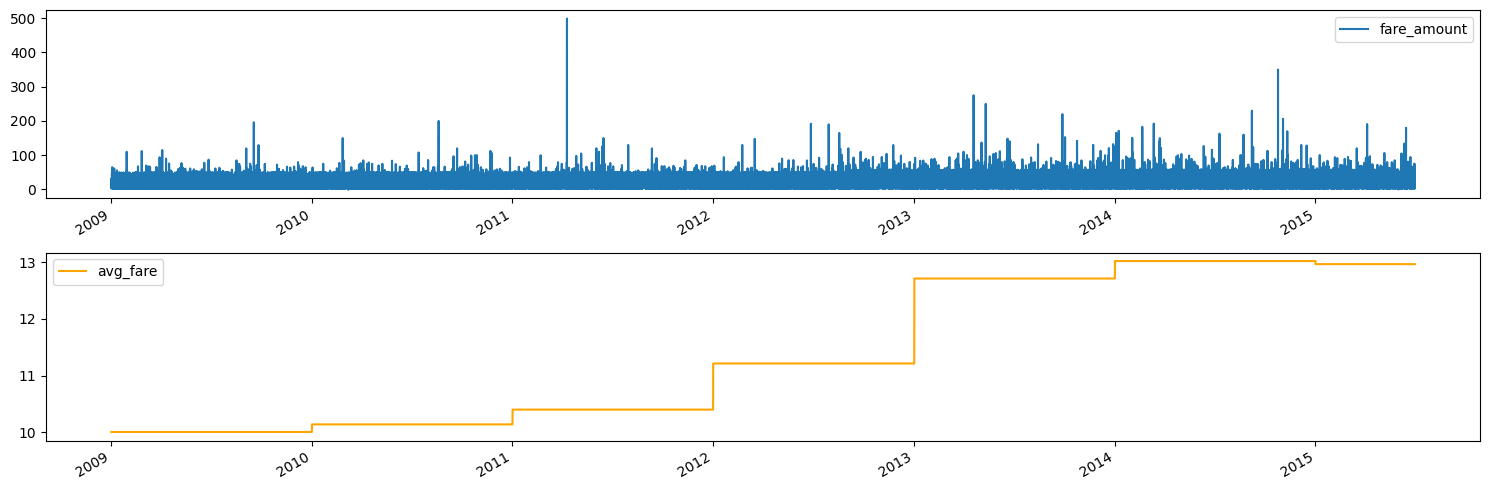

In [13]:
#| label: fig-fare-1
#| fig-cap: "Top panel shows individual fare prices over course of time. Bottom panel shows the change in average fare price over time."

#Look at fare amount change over time
fig, ax = plt.subplots(2,1, figsize=(15,5))

df.plot(x='timestamp', y='fare_amount', ax=ax[0])

(df.assign(avg_fare = lambda x: x['timestamp'].dt.year.map(df.groupby(df['timestamp'].dt.year)['fare_amount'].mean().to_dict()))
 .plot(x='timestamp', y='avg_fare', ax=ax[1], color='orange')
)

ax[0].set_xlabel("")
ax[1].set_xlabel("")

fig.tight_layout();

From @fig-fare-1, we see that there are a few large spikes but that the majority of the dataset is below \\$100. Additionally, we see that the average fare for an Uber ride has risen from \\$10 to \\$13 over the 6 year dataset. Accounting for large outliers in fares will be an important piece of data cleanup for us. 

To continue our investigation, we can plot out the average fare by the time of day as well as the number of rides in the same timeframe. Below in @fig-fare-2, we this result.

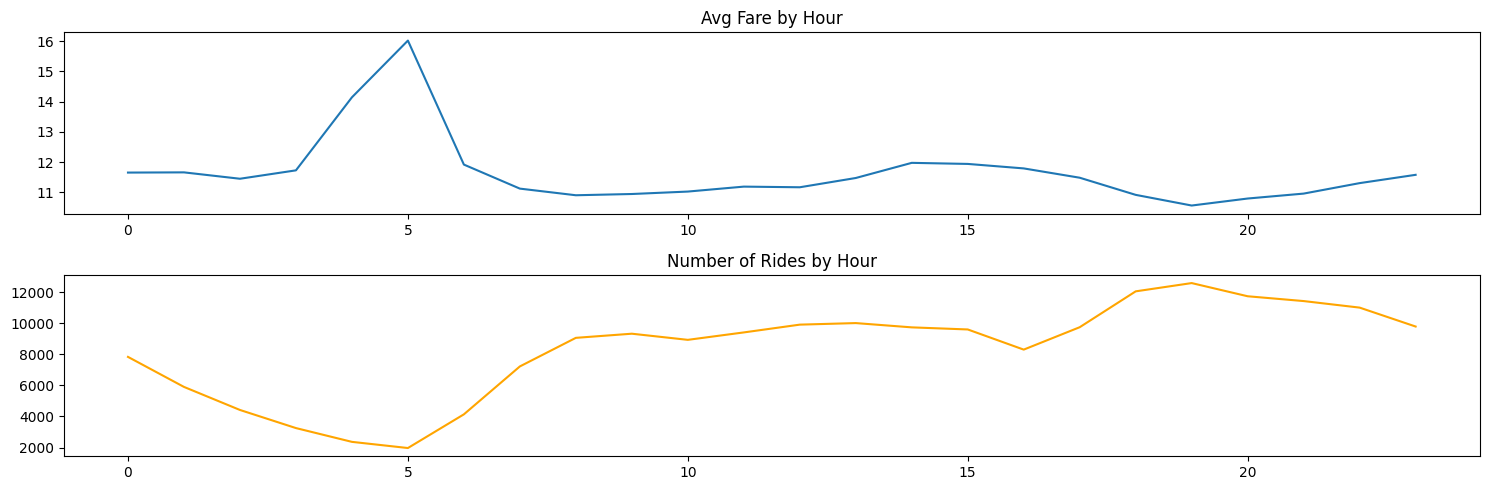

In [14]:
#| label: fig-fare-2
#| fig-cap: "Top panel shows average fare amount by the hour the ride was performed. Bottom panel shows the number of hides completed in a given hour."

#Look at avg fare at each hour and number of rides by hour
fig, ax = plt.subplots(2, 1, figsize=(15,5))

(df.groupby(df['timestamp'].dt.hour)['fare_amount'].mean()
 .plot(ax=ax[0])
)

(df.groupby(df['timestamp'].dt.hour)['id'].count()
 .plot(ax=ax[1], color='orange')
)

ax[0].set_title("Avg Fare by Hour")
ax[0].set_xlabel("")

ax[1].set_title("Number of Rides by Hour")
ax[1].set_xlabel("")

fig.tight_layout();

@fig-fare-2 shows that the average fare is relatively constant with exception to the early morning (about 3am-6am with highest peak at 5am). Contrastingly, the number of rides by hour shows that 5am is one of the least popular time to get a ride. The majority of rides appear to be towards the afternoon/evening. The peak at 5am makes more sense seeing how the 5am time has a lower sample, thus skewing the average towards extremes. 

Since we have data on location, we can plot the latitude vs longitude to see where these pickups and dropoffs occur. @fig-loc-1 illustrates this principle. 

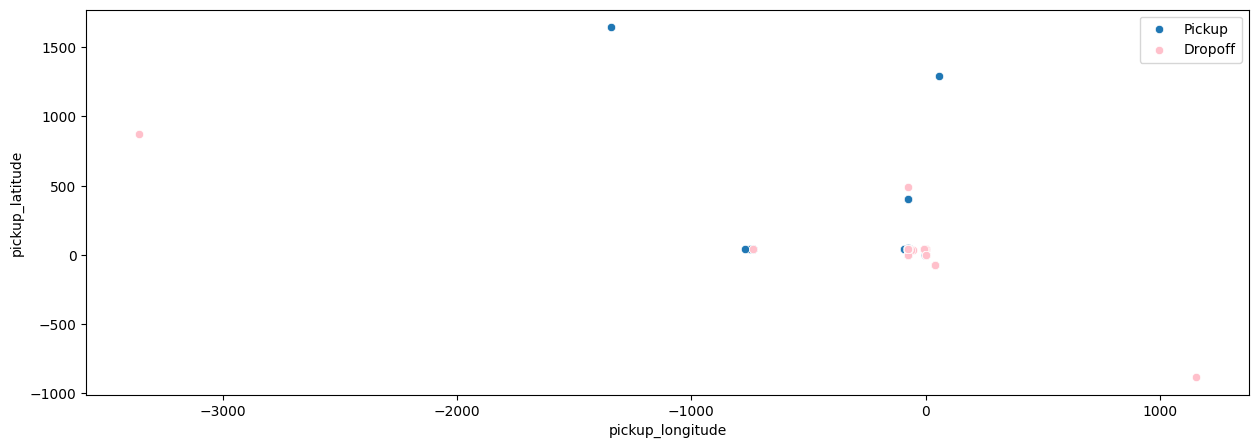

In [15]:
#| label: fig-loc-1
#| fig-cap: "Scatterplot of pickup vs dropoff locations"

#Look at scatterplot of pickup vs scatterplot of dropoff
fig, ax = plt.subplots(figsize=(15,5))

sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df, label="Pickup")
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=df, color='pink', label="Dropoff")

ax.legend();

Due to the spread of location in our dataset and possible repeat locations, there aren't too many dots recorded on the plot. We will need to ensure that these points are realistic locations in our dataset as we strive to model pricing of fares for these trips.

Having raw location data won't serve our modeling purposes (or at least won't be as easy to use). To extract the necessary information from these location data points, we will use the haversine distance formula to calculate the distance in miles between each pickup location to each respective dropoff location. 

After having performed this distance calculation, we can plot the relationship between distance of trip in miles and fare amount for said trip. @fig-fare-3 shows this relationship.

In [16]:
#Create function to calculate distance between pickup and dropoff
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [17]:
#Calculate distance between pickup and dropoff
df = (df.assign(trip_miles = np.vectorize(haversine)(df['pickup_longitude'], df['pickup_latitude'], 
                                                df['dropoff_longitude'], df['dropoff_latitude'])
          )
      .assign(trip_miles = lambda x: round(x['trip_miles'], 3))
)

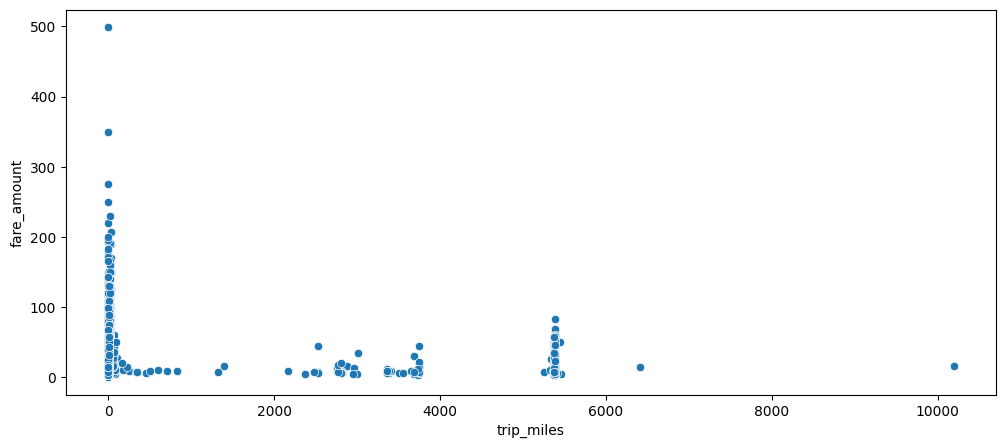

In [18]:
#| label: fig-fare-3
#| fig-cap: "Scatterplot illustrating the relationship between distance of trip in miles vs the fare amount of a trip."

#Plot scatterplot of trip in miles by fare amount
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(x='trip_miles', y='fare_amount', data=df);

We see that the great majority of trips are close to 0 with a wide range of their respective fare amounts (max of 500). Additionally, we see that there are a few outliers of super long trips (greater than 2000 miles!). I for one would not want to be an in Uber for 10000 miles and can't imagine where someone would even drive to for 10000 miles. We will address these errors in the data later on in the analysis. 

To confirm that these outliers are truly outliers, we can plot the distribution of miles per trip and fare amount per trip. This is shown in @fig-dist-1.

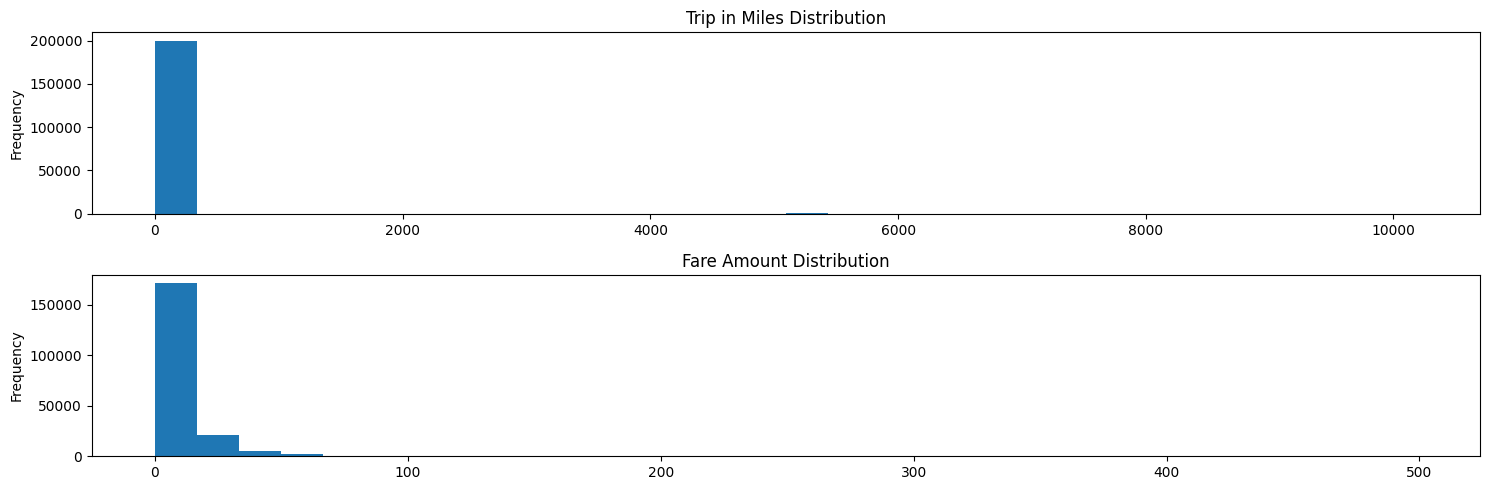

In [19]:
#| label: fig-dist-1
#| fig-cap: "Top panel shows distribution of miles per trip while bottom panel shows distribution of fare amount."

#Plot distributions of fare amount and trip miles
fig, ax = plt.subplots(2,1, figsize=(15,5))

df['trip_miles'].plot(kind='hist', ax=ax[0], bins=30)
df['fare_amount'].plot(kind='hist', ax=ax[1], bins=30)

ax[0].set_title("Trip in Miles Distribution")
ax[1].set_title("Fare Amount Distribution")

fig.tight_layout();

To solidify our findings, we view one more graph in @fig-dist-2.

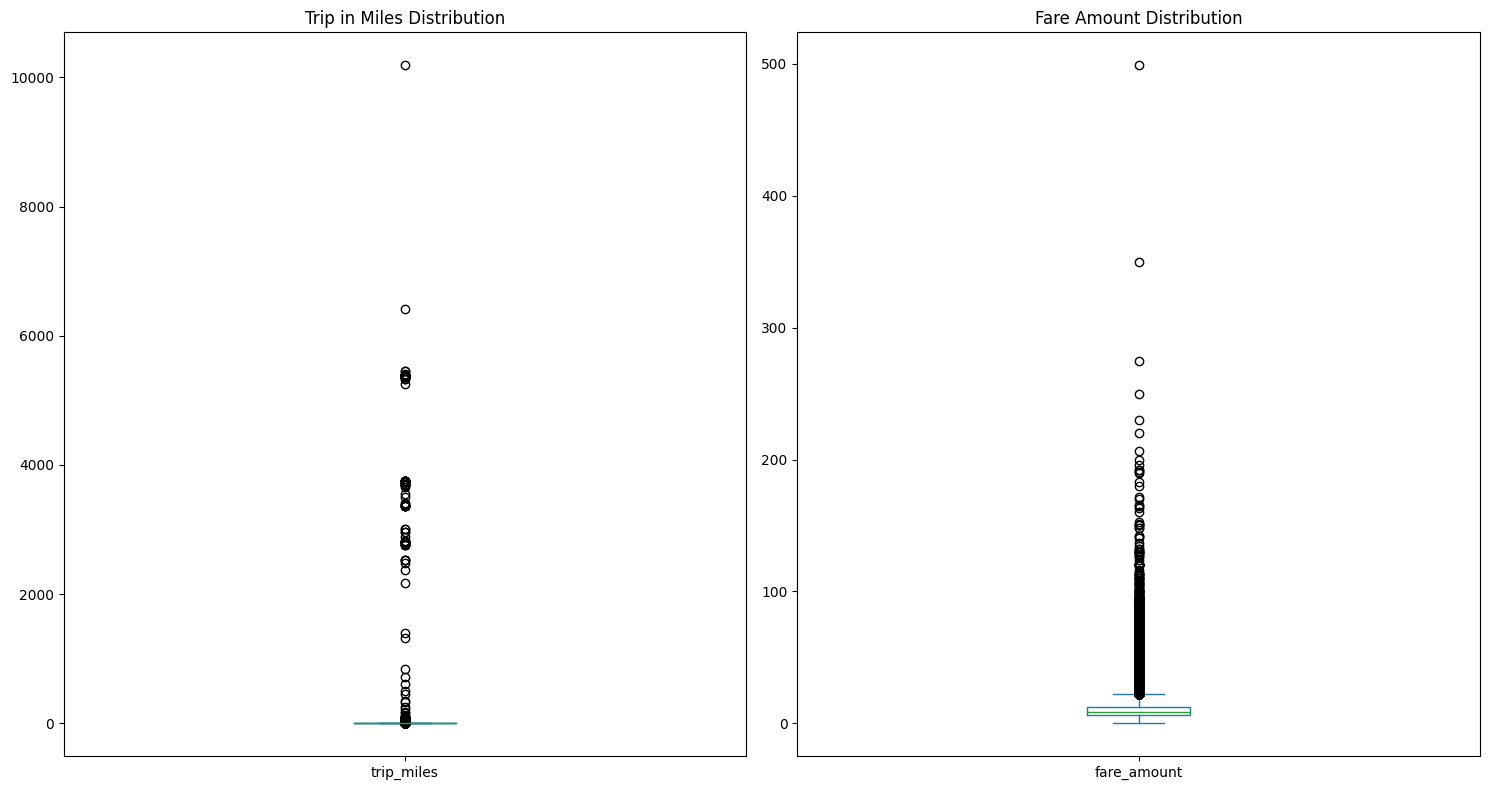

In [20]:
#| label: fig-dist-2
#| fig-cap: "Left panel shows distribution of trip in miles and right panel shows distribution of fare amount."

#Plot box and whisker plot of same distributions
fig, ax = plt.subplots(1,2, figsize=(15,8))

df['trip_miles'].plot(kind='box', ax=ax[0])
df['fare_amount'].plot(kind='box', ax=ax[1])

ax[0].set_title("Trip in Miles Distribution")
ax[1].set_title("Fare Amount Distribution")

fig.tight_layout();

Both @fig-dist-1 and @fig-dist-2 confirm that there are many outliers that need to accounted for in our model. In this analysis, we will remove these outliers since we have sufficient sample size without them. From our calculations, we decided to remove all observations with fare amounts greater than \\$30, trips with distance in miles greater than 10 miles, and there needs to be at least 1 passenger.

In [21]:
#Build function for outliers
def outlier_finder(s):
    lwr = np.quantile(s, .25)
    upr = np.quantile(s, .75)
    iqr = upr - lwr
    
    upr_limit = upr+(1.5*iqr)
    #lwr_limit = lwr-(1.5*iqr)
    
    print(f"Upper limit: {upr_limit}")

In [22]:
#| include: false

#Calculate outliers for fare amount
outlier_finder(df['fare_amount'])

Upper limit: 22.25


In [23]:
#| include: false

#Calculate outliers for trip miles
outlier_finder(df['trip_miles'])

Upper limit: 4.8825


In [24]:
#Drop outlier rows for miles (increase to 10 for including a few outliers) and for fare amount (increase to 30 for including a few outliers)
df = (df.query("fare_amount <= 30 and trip_miles <= 10 and passenger_count < 10 and passenger_count > 0")
     )

## Investigating Relationships with Fare Amount

As stated earlier, the purpose of this analysis is to analyze what, if anything, have effects on fare amount. We further this exploration in @fig-fare-4 where we check the distribution of fare amount by the passenger count.

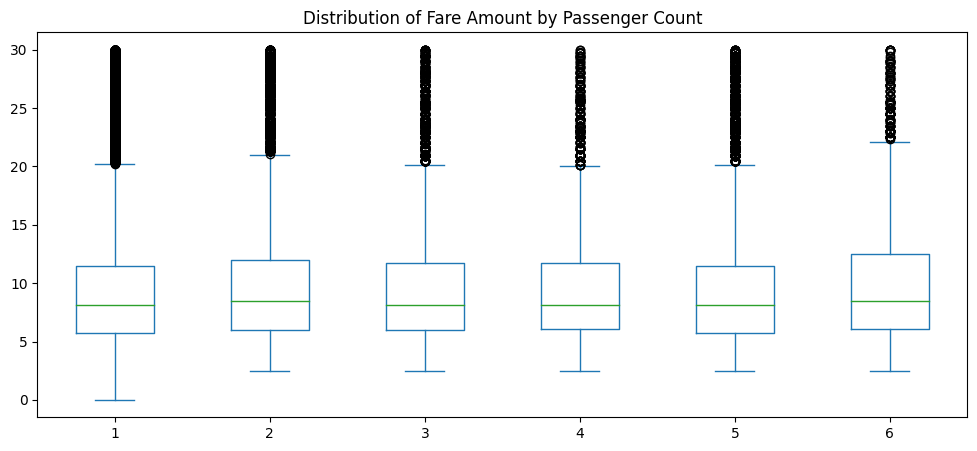

In [25]:
#| label: fig-fare-4
#| fig-cap: "Box-and-whisker plots showing the distribution of fare amount by passenger count."

#Look at distribution of fare amount split by passenger count
fig, ax = plt.subplots(figsize=(12,5))

(df.plot(kind='box', by='passenger_count', column='fare_amount', ax=ax))

ax.set_title("Distribution of Fare Amount by Passenger Count");

As we can see, the distributions among passenger count appear to be approximately the same. The median fare amount for each passenger count appears to be constant and each quartile appears to be relatively equal to the others. 

Another possible influence could be day of the week when a ride is taken. @fig-fare-5 shows the respective distributions of fare amount by weekday and weekend.

In [26]:
#Add weekend feature
df = (df.assign(is_weekend = lambda x: np.where(x['timestamp'].dt.dayofweek >= 5, True, False)))

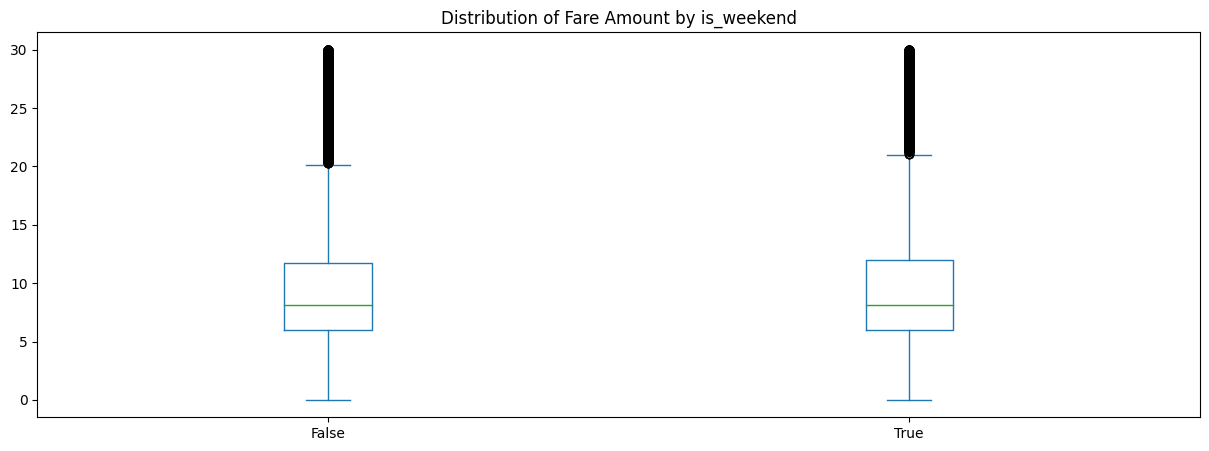

In [27]:
#| label: fig-fare-5
#| fig-cap: "Box-and-whisker plot showing distribution of fare amount by weekday vs weekend."

#Check distribution of fare by is_weekend
fig, ax = plt.subplots(figsize=(15,5))

(df.plot(kind='box', by='is_weekend', column='fare_amount', ax=ax))

ax.set_title("Distribution of Fare Amount by is_weekend");

Just as we saw in @fig-fare-4, @fig-fare-5 shows that there is not much difference between weekday and weekend trips with regard to fare amount. 

After having cleaned up our dataset, we can view a scatterplot of trip in miles vs fare amount, colored by weekend or weekday, to see the relationhsip between these variables. This is shown in @fig-fare-6.

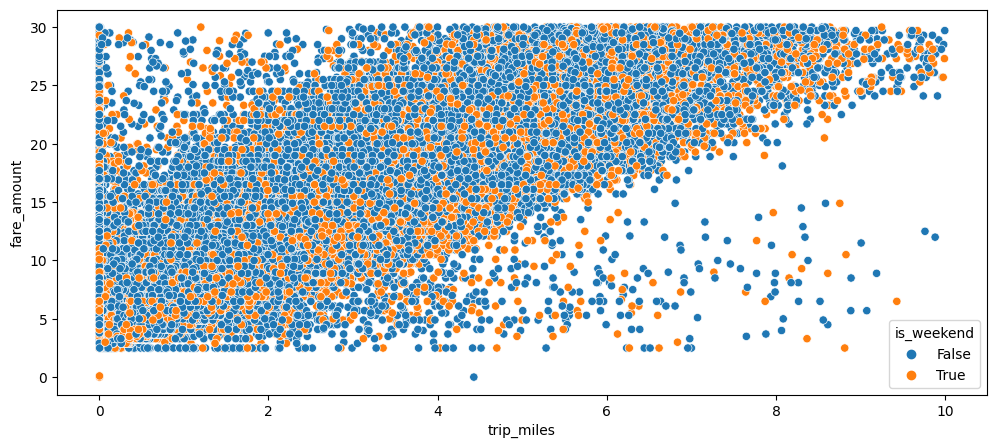

In [28]:
#| label: fig-fare-6
#| fig-cap: "Scatterplot of trip in miles vs fare amount, with each dot colored by weekend (orange) and weekday (blue)."

#Look at scatterplot of fare amount by trip_miles colored by is_weekend
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(x='trip_miles', y='fare_amount', hue='is_weekend', data=df);

Even after our data cleanup, we see in @fig-fare-6 that there is a large amount of data to still use. There appears to be a slight positive linear relationship between trip in miles vs fare amount. We will hope to quantify this when we build our model. There also appears to be a lot more rides during the week vs the weekend (which makes sense since there are more weekdays than weekends). 

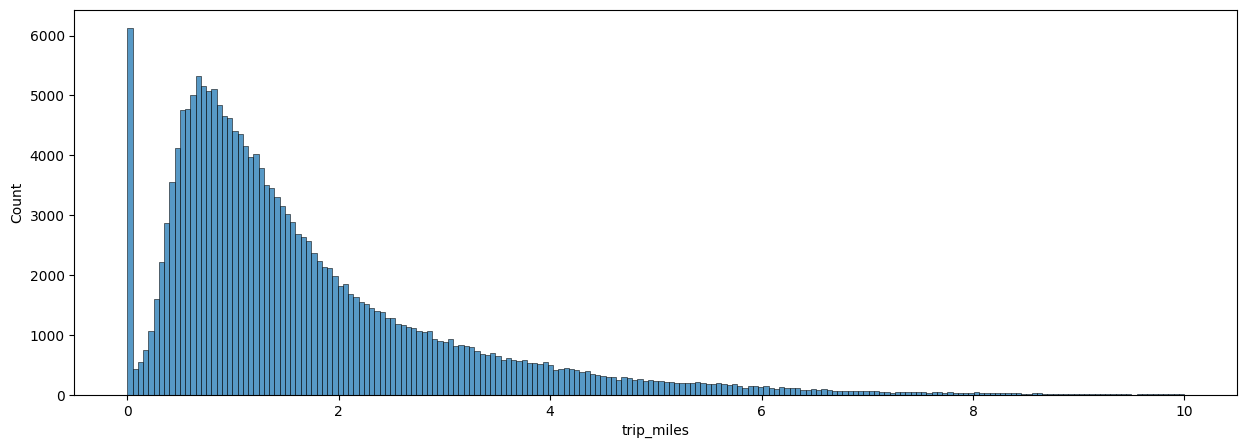

In [29]:
#| include: false

#View distribution of trip_miles
fig, ax = plt.subplots(figsize=(15,5))

sns.histplot(x='trip_miles', data=df, ax=ax);

## Check for Differences in Number of Rides by Hour

As we mentioned at the end of the previous section, there are more rides on weekdays vs weekends. We should continue to explore the difference in these different segments. First, we'll explore the difference in the number of rides by hour, split by weekdays vs weekends. This is shown in @fig-rides-1.

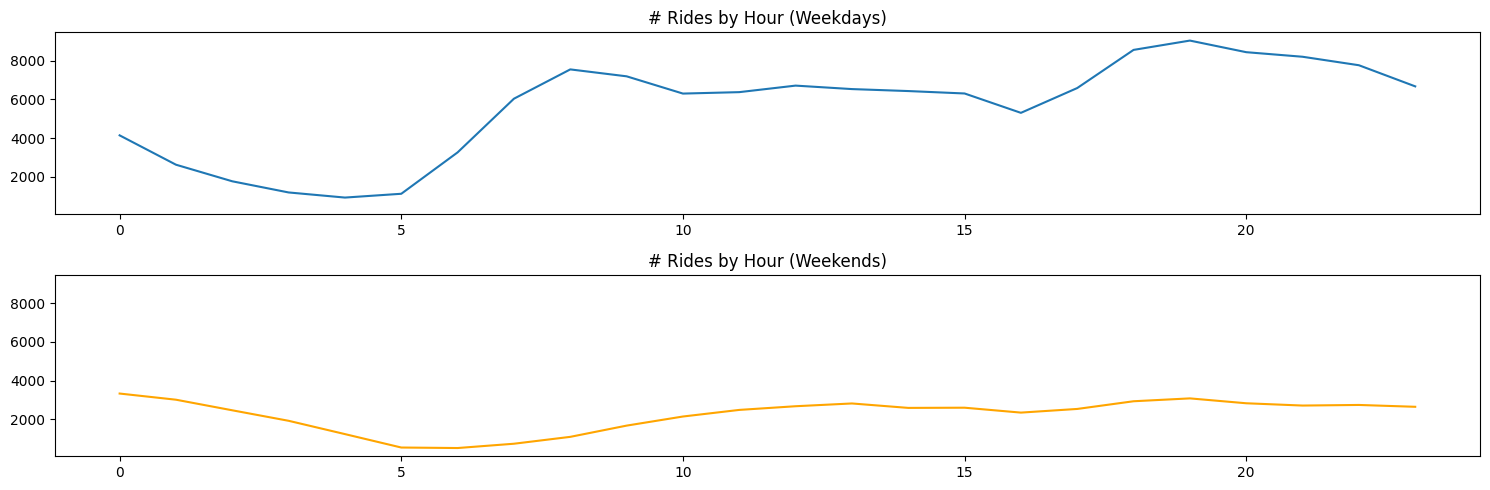

In [30]:
#| label: fig-rides-1
#| fig-cap: "Top panel shows number of rides by hour on weekdays. Bottom panel shows number of rides by hour on weekends."

#Compare number of rides per hour between weekday and weekend
fig, ax = plt.subplots(2,1, figsize=(15,5), sharey=True)

(df.query("is_weekend == False")
 .groupby(df['timestamp'].dt.hour)['id'].count()
 .plot(ax=ax[0]))

(df.query("is_weekend == True")
 .groupby(df['timestamp'].dt.hour)['id'].count()
 .plot(ax=ax[1], color="orange"))

ax[0].set_xlabel("")
ax[1].set_xlabel("")

ax[0].set_title("# Rides by Hour (Weekdays)")
ax[1].set_title("# Rides by Hour (Weekends)")

fig.tight_layout();

As we can see, although the total number of rides might differ between weekdays and weekends, the trend appears more or less the same. Weekdays have much heavier peaks around the usual rush hour commuting times. Weekends appear to steadily increase from morning to evening. 

In [31]:
#Add season feature
cond = [(df['timestamp'].dt.month == 12) | (df['timestamp'].dt.month < 3), 
        (df['timestamp'].dt.month >= 3) & (df['timestamp'].dt.month < 6),
        (df['timestamp'].dt.month >= 6) & (df['timestamp'].dt.month < 9),
        (df['timestamp'].dt.month >= 9) & (df['timestamp'].dt.month < 12)
       ]

choices = ["Winter", "Spring", "Summer", "Fall"]

df = (df.assign(season = np.select(cond, choices, default="None")))

While weekdays vs weekends are one possible segmentation for number of rides, seasons are also a potential group we should explore for delineations in number of rides. @fig-rides-2 shows the number of rides by hour for each season. 

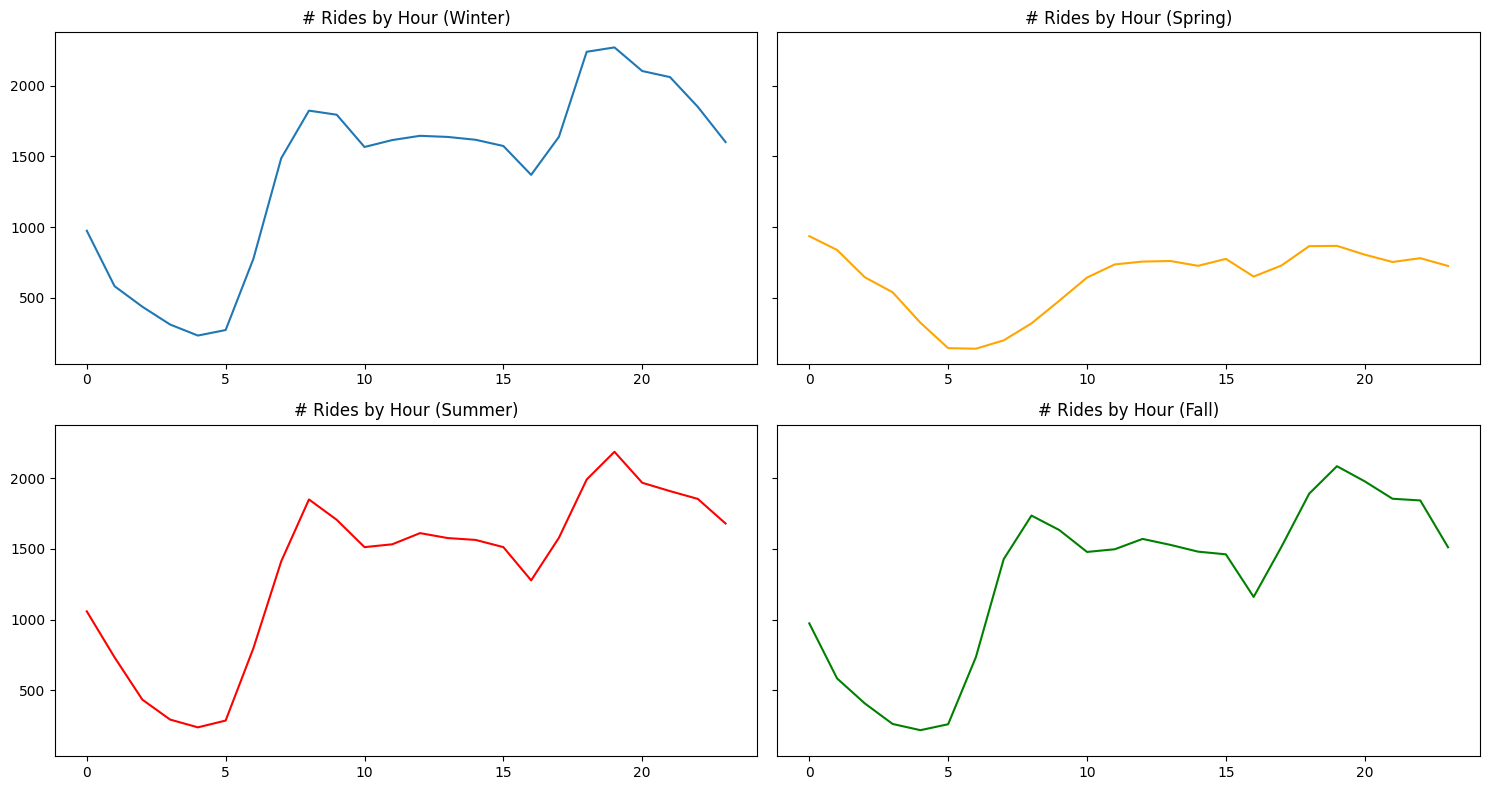

In [32]:
#| label: fig-rides-2
#| fig-cap: "2x2 grid showing number of rides by hour according to the labeled season."

#Check number of rides by hour split by season
fig, ax = plt.subplots(2,2, figsize=(15,8), sharey=True)

(df.query("is_weekend == False and season == 'Winter'")
 .groupby(df['timestamp'].dt.hour)['id'].count()
 .plot(ax=ax[0,0]))

(df.query("is_weekend == True and season == 'Spring'")
 .groupby(df['timestamp'].dt.hour)['id'].count()
 .plot(ax=ax[0,1], color="orange"))

(df.query("is_weekend == False and season == 'Summer'")
 .groupby(df['timestamp'].dt.hour)['id'].count()
 .plot(ax=ax[1,0], color='red'))

(df.query("is_weekend == False and season == 'Fall'")
 .groupby(df['timestamp'].dt.hour)['id'].count()
 .plot(ax=ax[1,1], color='green'))

ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")


ax[0,0].set_title("# Rides by Hour (Winter)")
ax[0,1].set_title("# Rides by Hour (Spring)")
ax[1,0].set_title("# Rides by Hour (Summer)")
ax[1,1].set_title("# Rides by Hour (Fall)")

fig.tight_layout();

There does not appear to be any differences between seasons, except for spring having very low peaks in comparison to the other 3 seasons. Generally speaking, each season follows the same trend of number of rides by hour, with winter, summer, and fall each following very similar trends and numbers. 

In [33]:
#Drop longitude values >= 0
df = (df.query("pickup_longitude < -1"))

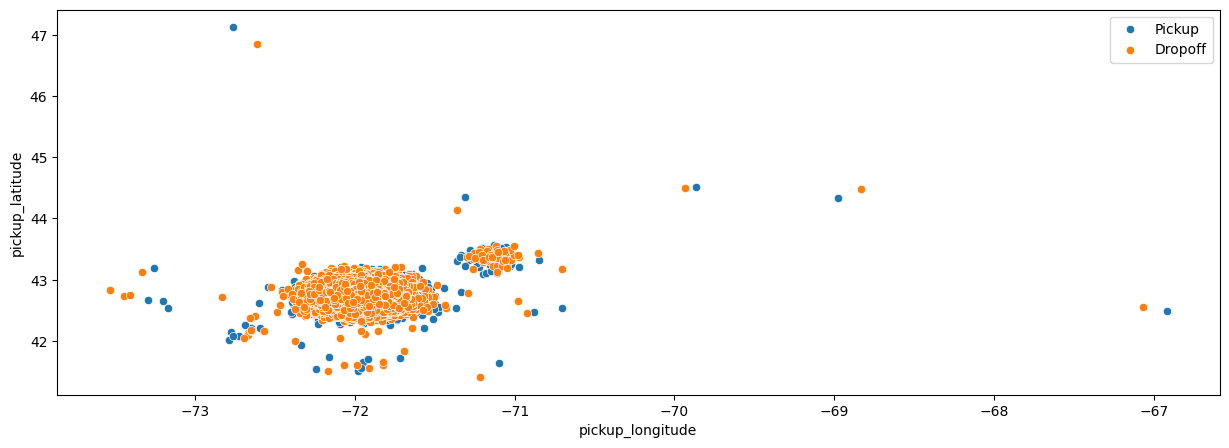

In [34]:
#| include: false

#Replot pickup and dropoff
def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(x=jitter(df['pickup_longitude'], 2), y=jitter(df['pickup_latitude'], 2), ax=ax, label="Pickup")
sns.scatterplot(x=jitter(df['dropoff_longitude'], 2), y=jitter(df['dropoff_latitude'], 2), ax=ax, label="Dropoff")

ax.legend();

In [35]:
#Segment rides into groups by hour
cond = [(df['timestamp'].dt.hour >= 0) & (df['timestamp'].dt.hour < 6), 
        (df['timestamp'].dt.hour >= 6) & (df['timestamp'].dt.hour < 10),
        (df['timestamp'].dt.hour >= 10) & (df['timestamp'].dt.hour < 15),
        (df['timestamp'].dt.hour >= 15) & (df['timestamp'].dt.hour < 20),
        (df['timestamp'].dt.hour >= 20)
       ]

choices = ['Dawn', 'Morning', 'Afternoon', 'Evening', 'Night']

df = df.assign(time_day = np.select(cond, choices, default="None"))

## Fare Amount by Time of Day and Season

We return to investigating fare amount since that is the principle objective of this analysis. One relationship we have yet to explore is the fare amount in relation to time of day. To do this, we will bucket each hour into a specific time of day (ie morning) and calculate the distributio of fare prices at that respective time. @fig-fare-7 shows this distribution.

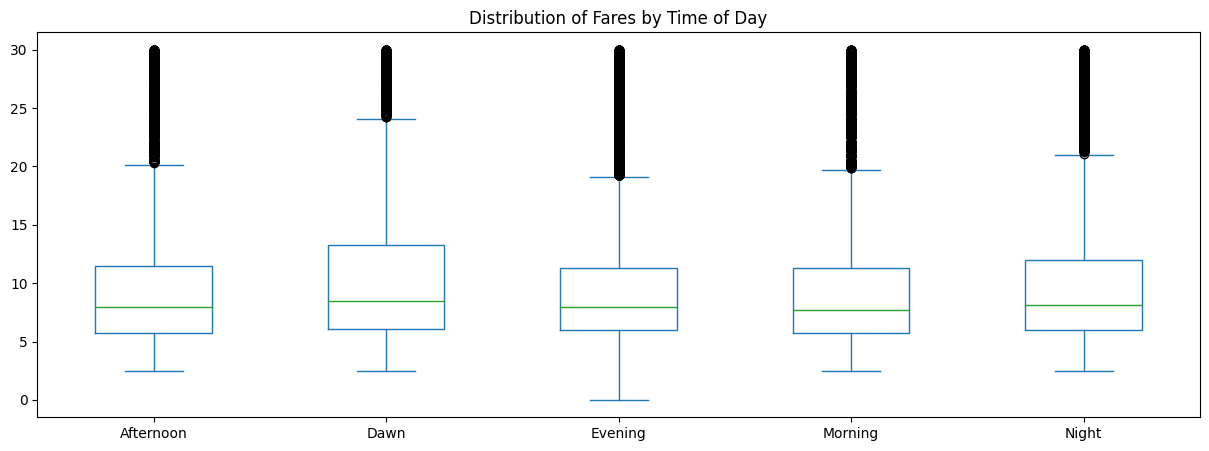

In [36]:
#| label: fig-fare-7
#| fig-cap: "Box-and-whisker plot showing distribution of fare amount by bucketed time of day."

#View boxplot of fare_amount by time_day
fig, ax = plt.subplots(figsize=(15,5))

(df.plot(kind='box', by='time_day', column='fare_amount', ax=ax))

ax.set_title("Distribution of Fares by Time of Day");

From @fig-fare-7, we see that there is no real difference in distributions. Dawn appears to have the highest variance of the 5 time buckets, but does not appear to be significant. 

To combine some of the relationships we have explored thus far, we will look at the change in average fare, split by season and time of day. Perhaps a combination of these segments could show a possible difference in fare price. @fig-fare-8 shows this relationship.

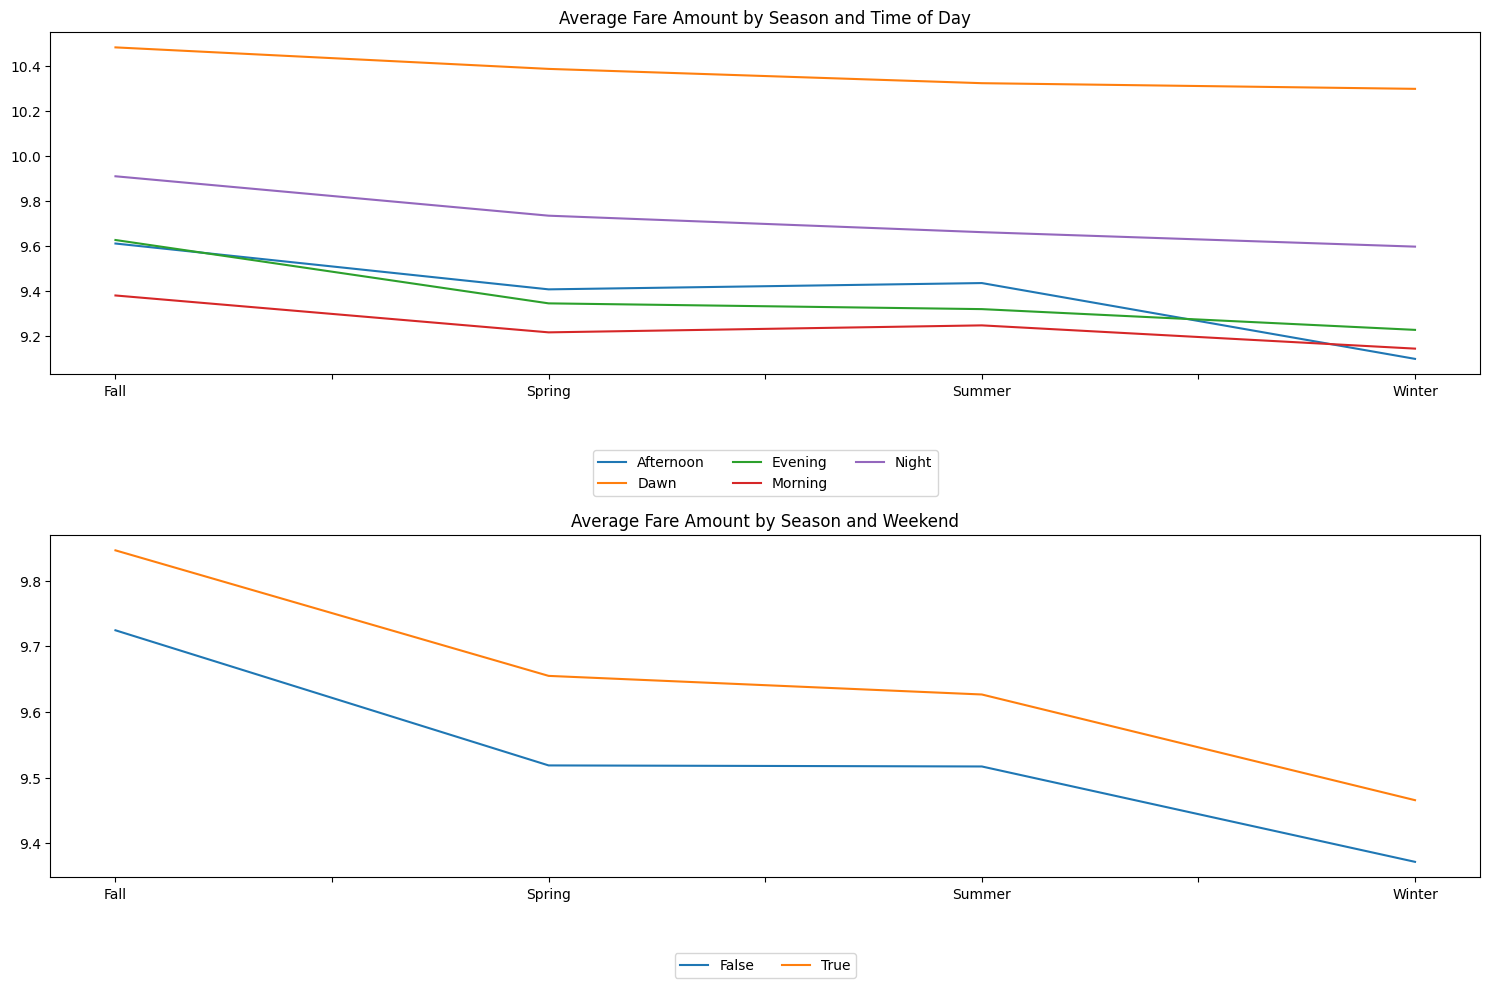

In [37]:
#| label: fig-fare-8
#| fig-cap: "Top panel shows the average fare price and its change over seasons, split by time of day. Bottom panel shows the average fare amount by season, split by weekday vs weekend."

#Look at average fare by season, time of day, and weekend
fig, ax = plt.subplots(2,1, figsize=(15,10))

(df.pivot_table(values='fare_amount', index='season', columns='time_day', aggfunc='mean')
 .plot(ax=ax[0]))

(df.pivot_table(values='fare_amount', index='season', columns='is_weekend', aggfunc='mean')
 .plot(ax=ax[1]))

ax[0].set_title("Average Fare Amount by Season and Time of Day")
ax[0].set_xlabel("")
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
ax[1].set_title("Average Fare Amount by Season and Weekend")
ax[1].set_xlabel("")
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
fig.tight_layout();



@fig-fare-8 is very informative as it shows clear delineations between average fare prices. The top panel shows that dawn by far has the highest average fare price over the other 4 time of day buckets. The closest to each other are evening and afternoon across all seasons. Interestingly, afternoon has a sharp dip in average fare price in the winter. The average afternoon fare price in winter is the lowest, followed closely by morning and evening. While we do notice clear separation between these lines, we should recognize that these prices are within essentially a dollar a part. 

The bottom panel of @fig-fare-8 shows a clear (yet small in dollar value) difference between weekend and non-weekend average fare amounts across seasons. Weekends on average have a higher fare amount than weekdays across all seasons. Additionally, The difference appears constant between the average fare amount of weekends and weekdays across all seasons. @fig-fare-8 shows the usefulness of these features in helping the model capture defined segments across the data.

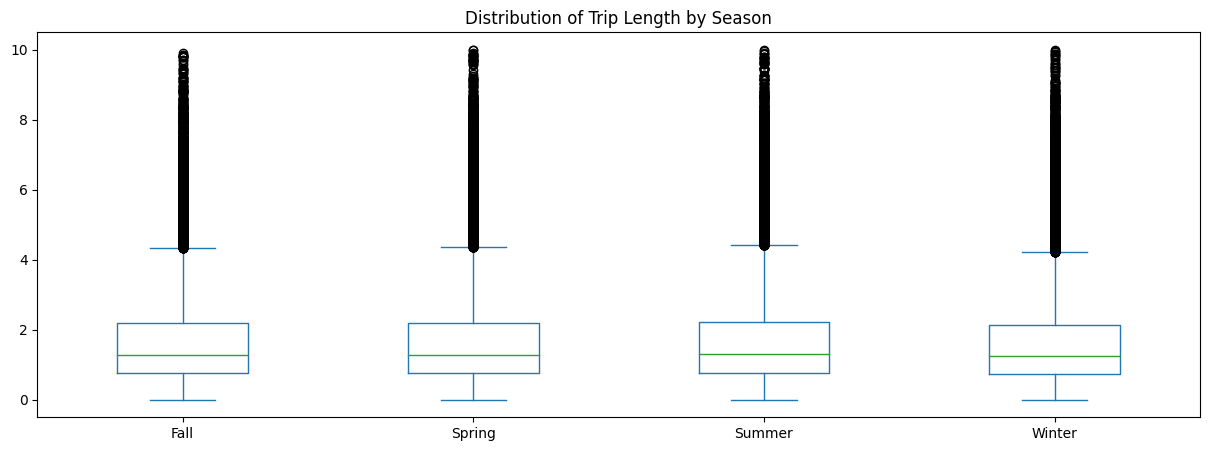

In [38]:
#| include: false

#Look at distribution of trip length by season
fig, ax = plt.subplots(figsize=(15,5))

(df.plot(kind='box', by='season', column='trip_miles', ax=ax))
ax.set_title("Distribution of Trip Length by Season");

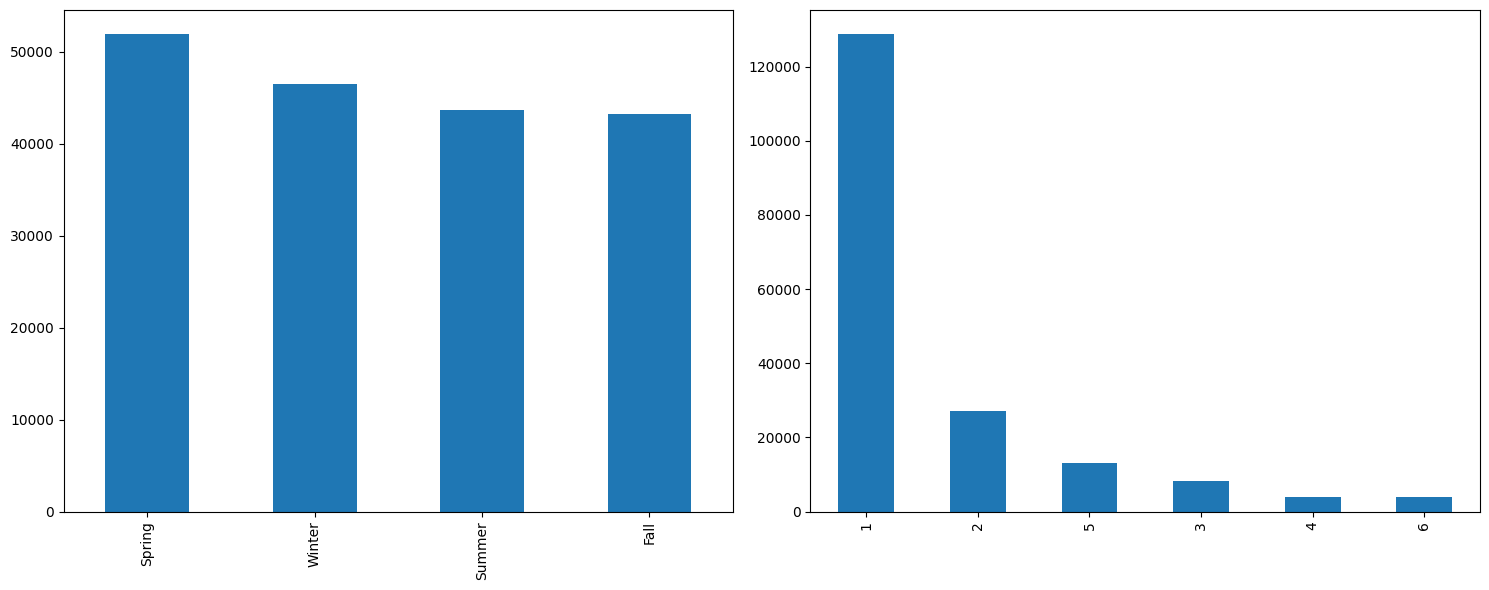

In [39]:
#| include: false

#Number of trips by season and number of trips by passenger count
fig, ax = plt.subplots(1,2, figsize=(15,6))

(df['season'].value_counts().plot(kind='bar', ax=ax[0]))
(df['passenger_count'].value_counts().plot(kind='bar', ax=ax[1]))

ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.tight_layout();

# Bayesian Modeling

After having explored the data, the next step is to write out our model to identify how we will model the effect of certain features on the response variable of fare amount. A flexible and useful model to do this is a linear regression model. To do fit this model, we will need to list the variables $x_i$ that we will use to explain our response $y_i$. Our written model is found below.

$$
Y_{i} = \beta^{T}x_{i} + \epsilon_{i}
$$
$$
\epsilon_{i} \sim \text{i.i.d. } N(0, \sigma^{2})
$$

Each observation of fare amount is modeled as a linear function of explanatory variables times beta values, plus our error term $\epsilon_{i}$ to account for variantion in the data. The explanatory variables we chose to use for this analysis are the following: passenger count, trip_miles, is_weekend, season_spring, season_summer, season_summer, time_day_dawn, time_day_evening, time_day_morning, time_day_night. Notice that season_fall, is_weekday, and time_afternoon are not included in the explanatory variable list. These values are included in the model, but are set as the baseline of the model. Essentially, our $\beta_{0}$ value will represent a beginning point for the change in fare amount for a trip in fall, on a weekday, in the afternoon. All other $\beta$ values will be modeled as either additions to or deductions from this baseline value. 

Additionally, since this is TheBayesianBandit blog, this will be a bayesian analysis and subsequently, require that we write out priors for our parameters of interest and derive a posterior distribution for these. Below is the bayesian addition to our model approach.

$$
\theta = (\beta_{0} ... \beta_{p-1})
$$
$$
Y \sim MVN(X\beta, \sigma^{2})
$$
$$
p(\theta) \sim N(0, 3)
$$
$$
p(\sigma^{2}) \sim IG(3, 1)
$$
$$
p(\theta|D) \propto p(\theta)p(D|\theta)
$$

Our primary parameter of interest in this study is the parameter $\theta$, which is a vector of $\beta$ values corresponding to each explanatory variable in our dataset. We propose that fare amount is modeled by a multivariate normal distribution with mean $X\beta$ and variance $\sigma^{2}$. $\theta$ is proposed to be distributed normally with mean 0 and standard deviation of 3. $\sigma^{2}$ is proposed to be distributed by an inverse-gamma distribution with $\alpha$ = 3 and $\beta$ (rate beta, not LR beta) = 1. Utilizing these values, we derive the posterior distribution for $\theta$ based on the data updates from our model. To do this, we will utilize a NUTS sampler with 1000 warmup samples and 2500 samples. Furthermore, we have split our data into train-test splits, with 67% of the data belonging to training and 33% belonging to testing. The results of our sampler are found below.  

In [40]:
#Get dummy variables
mod_df = pd.get_dummies(df, columns=['is_weekend', 'season', 'time_day'], drop_first=True, dtype='int32')

In [41]:
#Perform train-test split
drop_cols = ['id', 'timestamp', 'pickup_datetime', 'pickup_longitude', 
             'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
             'fare_amount']
X = mod_df.drop(drop_cols, axis=1)
y = mod_df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
# #Define ecs function
# def bayes_pooled_mod_ecs(X_vars, y_res):
#     X_temp = jnp.hstack([jnp.ones((X_vars.shape[0], 1)), X_vars])
    
#     #Initialize prior for beta
#     beta = numpyro.sample("beta", dist.Normal(0, 1).expand([X_temp.shape[1]]))
    
#     #Initialize prior for sigma
#     sigma = jnp.sqrt(numpyro.sample("sigma", dist.InverseGamma(1,1)))
    
#     #Calculate mu
#     #mu = jnp.dot(X_temp, beta)
    
#     #Sample model
#     with numpyro.plate("data", X_temp.shape[0], subsample_size=15000):
#         batch_x = numpyro.subsample(X_temp, event_dim=1)
        
#         if y_res is None:
#             batch_y = None
#         else:
#             batch_y = numpyro.subsample(y_res, event_dim=0)
        
#         numpyro.sample("obs", dist.Normal(beta @ batch_x.T, sigma), obs=batch_y)

In [43]:
#Define reg mcmc function
def bayes_pooled_mod(X_vars, y_res):
    X_temp = jnp.hstack([jnp.ones((X_vars.shape[0], 1)), X_vars])
    
    #Initialize prior for beta
    beta = numpyro.sample("beta", dist.Normal(0, 3).expand([X_temp.shape[1]]))
    
    #Initialize prior for sigma
    sigma = jnp.sqrt(numpyro.sample("sigma", dist.InverseGamma(3,1)))
    
    #Calculate mu
    mu = jnp.dot(X_temp, beta)
    
    #Sample model
    with numpyro.plate("data", X_temp.shape[0]):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=y_res)

In [44]:
#Initialize rng_key
rng_key = random.PRNGKey(0)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [45]:
# #Run sampler
# pooled_kernel = NUTS(bayes_pooled_mod)
# pooled_mcmc = MCMC(pooled_kernel, num_warmup=1000, num_samples=2500)
# pooled_mcmc.run(rng_key, X_train.values, y_train.values)

In [46]:
# #Save pooled_mcmc
# with open('pooled_mcmc.pkl', 'wb') as file:
#     pickle.dump(pooled_mcmc, file)
#     file.close()

In [47]:
#Open pooled_mcmc
with open('pooled_mcmc.pkl', 'rb') as file:
    pooled_mcmc = pickle.load(file)
    file.close()

In [48]:
#Print summary of sampler
pooled_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      4.69      0.03      4.69      4.65      4.73   1296.49      1.00
   beta[1]      0.05      0.01      0.05      0.04      0.06   4623.29      1.00
   beta[2]      3.25      0.01      3.25      3.24      3.26   3806.85      1.00
   beta[3]     -0.26      0.02     -0.26     -0.29     -0.23   3442.71      1.00
   beta[4]     -0.22      0.02     -0.22     -0.26     -0.19   1632.68      1.00
   beta[5]     -0.34      0.02     -0.34     -0.38     -0.31   1502.49      1.00
   beta[6]     -0.26      0.02     -0.26     -0.29     -0.22   1710.00      1.00
   beta[7]     -1.00      0.03     -1.00     -1.04     -0.95   1962.38      1.00
   beta[8]     -0.19      0.02     -0.19     -0.22     -0.15   1530.76      1.00
   beta[9]     -0.58      0.03     -0.58     -0.62     -0.53   1851.44      1.00
  beta[10]     -0.78      0.02     -0.78     -0.82     -0.74   1941.79      1.00
     sigma      7.35      0

As we mentioned earlier in this section, our $\beta_{0}$ represents our baseline distribution for fare amount for a trip taken in fall, on a weekday, in the afternoon. On average, this value is about 4.69. Our 95% credible interval indicates this would be anywhere from 4.65 to 4.73 with 95% probability.

It is interesting to not that the only increase in fare amounts come from $\beta_{1}$ and $\beta_{2}$, which are the changes in fare amount based on the value of number of passengers and trip in miles, respectively. On average, for every 1 mile increase in the trip, the fare amount goes up by 3.25 dollars. Conversely, for trips taken in at dawn ($\beta_{7}$), this results in an average decrease of 1 dollar from the fare amount. 

In order to know if we can trust these numbers, we need to check the n_eff values, the r_hat values, and the trace plots for each beta in order to verify that each parameter has converged and each parameter has achieved good mixing. Above, we see that each parameter achieved a r_hat value of 1, which indicates convergence. The n_eff value shows the effective sample size for each parameter and since each value is a good ratio with regard to the number of samples we drew with our sampler, this is also verified. Below in @fig-trace-1 we analyze the trace plots for each beta value. 

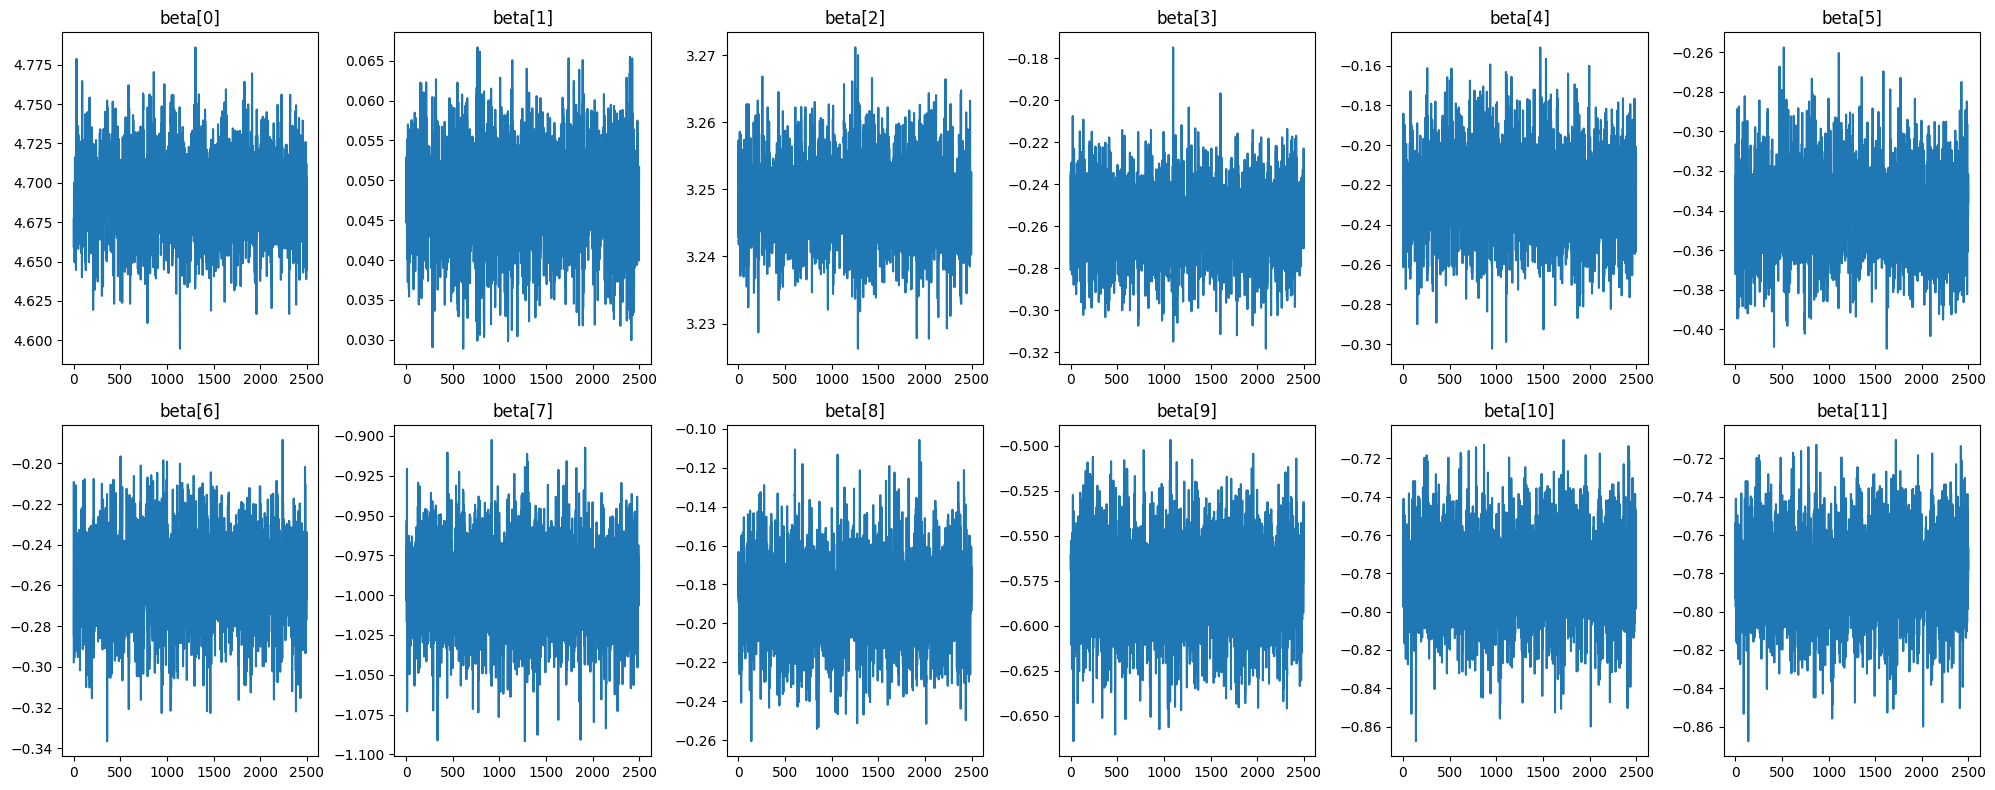

In [49]:
#| label: fig-trace-1
#| fig-cap: 2x6 grid of trace plots for each beta value. Beta value 11 is just a repeat of 10 since there are not 12 beta values.

#Display trace plots for each beta
fig, ax = plt.subplots(2,6, figsize=(20,8))

for i, a in enumerate(ax.flatten()):
    a.plot(pooled_mcmc.get_samples()['beta'][:,i])
    a.set_title(f"beta[{i}]")
    
fig.tight_layout();

@fig-trace-1 shows that each beta value appears to have good mixing and has achieved an acceptable level of stationarity. We will proceed with the analysis trusting in the numbers generated from our sampler. We can now proceed to view the posterior distribution of each beta value from our model. This is shown in @fig-dist-3.

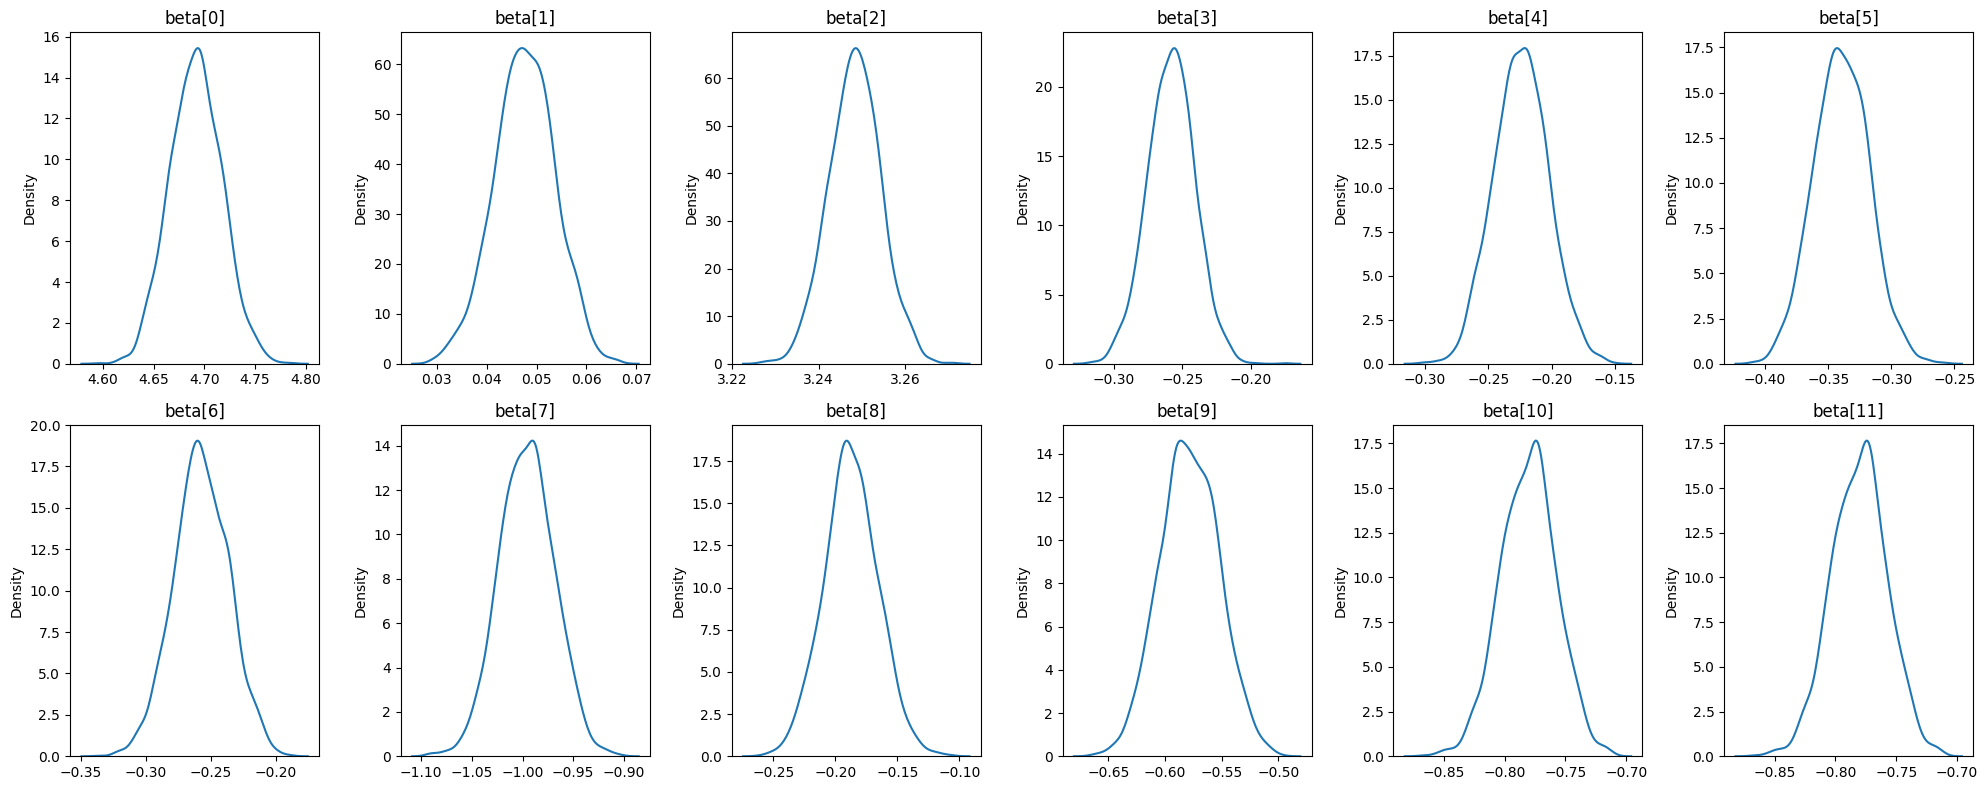

In [50]:
#| label: fig-dist-3
#| fig-cap: "2x6 grid of density plots for each beta value. Beta[11] is merely a repeat of beta[10]."

#Look at posterior distribution for each beta
fig, ax = plt.subplots(2,6, figsize=(20,8))

for i, a in enumerate(ax.flatten()):
    sns.kdeplot(pooled_mcmc.get_samples()['beta'][:,i], ax=a)
    a.set_title(f"beta[{i}]")
    
fig.tight_layout();

@fig-dist-3 shows that each beta value is sharply peaked with very little variation from the mean. As mentioned previously, all beta values along their entire distribution appear to have a negative impact on fare amount, with exception to beta[1] (number of passengers) and beta[2] (trip in miles). It is worth noting that while some values are close to 0, none of them ever cross the 0 threshold. 

Now that we have a posterior distribution for each beta value, we can generate predictions from our test set. Our values for RMSE, coverage, and width are shown below.

In [51]:
#Generate predicitons
preds_dict = {}
for i in range(X_test.shape[0]):
    preds_dict[i] = np.dot(X_test.values[i,:], pooled_mcmc.get_samples()['beta'][:,1:].T) + pooled_mcmc.get_samples()['beta'][:,0]

In [52]:
#Calculate point predictions using RMSE
rmse = []
for i in range(X_test.shape[0]):
    rmse.append(np.sqrt((y_test.iloc[i] - preds_dict[i].mean())**2))
rmse = np.array(rmse)

In [53]:
#Calculate coverage  and width of PIs
cvg = []
width = []
for i in range(X_test.shape[0]):
    lwr = np.quantile(preds_dict[i], .025)
    upr = np.quantile(preds_dict[i], .975)
    
    cvg.append((y_test.iloc[i] >= lwr) & (y_test.iloc[i] <= upr))
    width.append(upr - lwr)
    
cvg = np.array(cvg)
width = np.array(width)

In [54]:
#Report Metrics
print(f"RMSE: {rmse.mean():.2f}")
print(f"Coverage: {cvg.mean():.2f}")
print(f"Width: {width.mean():.2f}")

RMSE: 1.84
Coverage: 0.02
Width: 0.10


On average, our predictions are off by about 1.84 dollars. Comparing this value to the standard deviation of the fare amount distribution (5.17), this is a good sign that our model has good predictive power. Unfortunately, our coverage does not score well with only 2% coverage over the test set. However, this is not too bad of a loss, since the width of these intervals are usually around .10. Since the width of these predictions are so narrow, it is normal to have low coverage. Nonetheless, we should investigate ways to improve coverage so that our predictions always lie within our 95% PIs.

## Simple Prediction Demonstration

To demonstrate how our model predicts, we will make a prediction for a single passenger, riding 5 miles, in the winter, in the morning, on a weekday. Using our estimated beta distributions above, we obtain the posterior predictive distribution in @fig-dist-4. 

In [55]:
#Get prediction for single passenger riding 5 miles in winter during the morning on a weekday
temp_array = np.array([1., 5., 0., 0., 0., 1., 0., 0., 1., 0.])

temp_pred = np.dot(temp_array, pooled_mcmc.get_samples()['beta'][:,1:].T) + pooled_mcmc.get_samples()['beta'][:,0].T

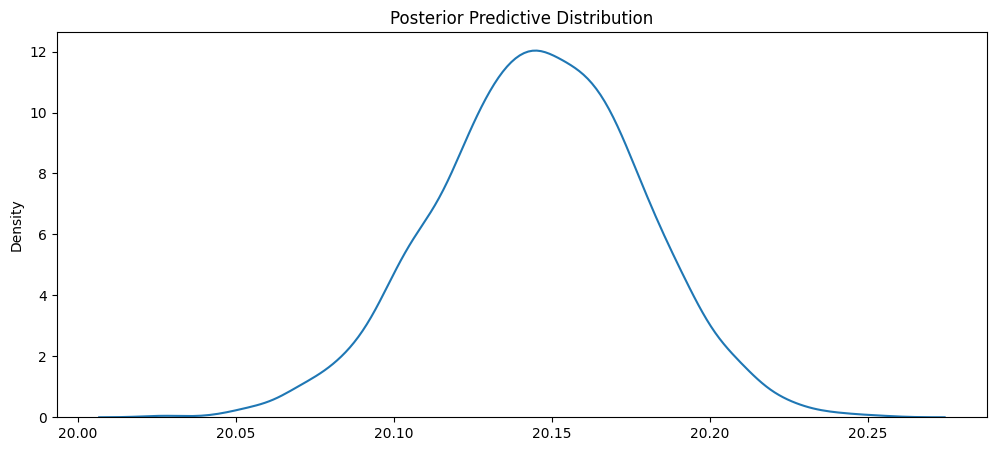

In [56]:
#| label: fig-dist-4
#| fig-cap: "Posterior predictive density for a single passenger riding 5 miles in winder during the morning on a weekday."

#Plot distribution of prediction
fig, ax = plt.subplots(figsize=(12,5))

sns.kdeplot(temp_pred, ax=ax)
ax.set_title("Posterior Predictive Distribution");

From @fig-dist-4, it appears that the average fare amount for a ride like this would be around 20.15 dollars. Approximate 95% PI would be (20.10, 20.20). Our model makes very precise predictions as evident by the short width of the distribution. Nonetheless, this illustrates very well how our bayesian linear model makes a predictive distribution instead of just a single point estimate. We have a small amount of uncertainty around this estimate due to the large amount of training data. 

# Conclusions

We demonstrated very briefly in this analysis the abililty to analyze ride share data by extracting meaningful featrues form raw form. We showed that there were reasonably viable features to use to understand how fare amount is estimated. We built a bayesian linear model that calculates the effect of each feature on fare amount, showing uncertainty with each estimate based on each value's posterior distribution. We reviewed the predictive capabilites of the lienar model by estimating metrics like RMSE and coverage. While RMSE proved to be low, coverage also was very low due to the small widths of our posterior predictive distributions. Further enhancements to the model can be made, such as incorporating interactions, engineering new features from the raw data, or utilizing a different sampler/different numbers for different results. Overall, we are pleased with the results of our model. We have succesfully crafted a model that predicts fairly well the fare amount for rides on Uber.